In [1]:
from collections import defaultdict
import json
import os
from string import Template

import numpy as np
from tqdm import tqdm


# QUERY_CONF_THRESHOLDS = [x/100 for x in range(0, 101, 10)]
QUERY_CONF_THRESHOLDS = [0.7]
DOC_LOWER_THRESHOLDS = [x/100 for x in range(0, 101, 10)]
DOC_UPPER_THRESHOLDS = [x/100 for x in range(0, 101, 10)]

# RERANKER = "colbert"
RERANKER = "rankgpt-qwen7b"

# dataset_names = ['nq', 'hotpotqa', 'dbpedia-entity', 'fever']
dataset_names = ['dbpedia-entity']

IMG_PATH_TEMPLATE = Template(f"data/new/param/Figure_6_$dataset_name-bm25-{RERANKER}-q100-qwen7b-$filename")

SCORE_PATH_TEMPLATE = Template(f"/mnt/s2t/backup/sda/rerank/score/$dataset_name-bm25-{RERANKER}-q100-qwen7b.json")

METHOD_NAME = "three_bins"

EVAL = ('ndcg', 'NDCG@10')

dataset_mapping = {
    'nq': 'NaturalQuestions',
    'hotpotqa': 'HotpotQA',
    'dbpedia-entity': 'DBPedia-Entity',
    'fever': 'FEVER',
    'avg': 'Average'
}


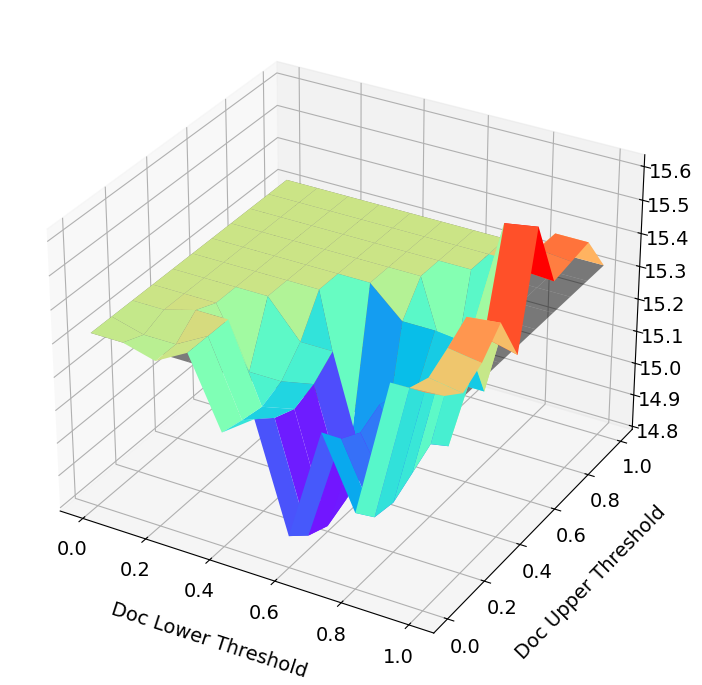

In [30]:
from matplotlib import pyplot as plt


def draw3d(qt_scores, base_score, title, figure_path):
    base_score_percent = round(base_score[EVAL[0]][EVAL[1]]*100, 3)

    data = np.zeros((len(DOC_LOWER_THRESHOLDS), len(DOC_UPPER_THRESHOLDS)))
    for lt in DOC_LOWER_THRESHOLDS:
        for ut in DOC_UPPER_THRESHOLDS:
            if lt <= ut:
                s = qt_scores[str(lt)][str(ut)][EVAL[0]][EVAL[1]]
                s = round(s*100, 3)
                data[int(lt*10)][int(ut*10)] = s
            else:
                data[int(lt*10)][int(ut*10)] = base_score_percent

    fig = plt.figure(figsize=(8, 8))
    # fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.array(DOC_LOWER_THRESHOLDS)
    y = np.array(DOC_UPPER_THRESHOLDS)
    x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, data, cmap='rainbow')

    # base
    x = np.array(DOC_LOWER_THRESHOLDS)
    y = np.array(DOC_UPPER_THRESHOLDS)
    x, y = np.meshgrid(x, y)
    
    z = np.full(x.shape, base_score_percent)
    ax.plot_surface(x, y, z, color='black', alpha=0.5)

    ax.set_xlabel('Doc Lower Threshold', fontsize=14)
    ax.set_ylabel('Doc Upper Threshold', fontsize=14)
    ax.set_zlabel(f'Score', fontsize=14)
    if title:
        ax.set_title(title)

    # set tick font size
    tick_params = {'labelsize': 14}
    ax.tick_params(axis='x', **tick_params)
    ax.tick_params(axis='y', **tick_params)
    ax.tick_params(axis='z', **tick_params)
    
    ax.xaxis.labelpad = 15
    ax.yaxis.labelpad = 15
    ax.zaxis.labelpad = 15

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.savefig(figure_path)
    plt.show()
    plt.close()

for dataset_name in dataset_names:
    
    with open(SCORE_PATH_TEMPLATE.substitute(dataset_name=dataset_name), 'r') as f:
        all_scores = json.load(f)

    prev_score = all_scores['prev_score']
    param_scores = all_scores[METHOD_NAME]['all_scores']

    for qt in QUERY_CONF_THRESHOLDS:
        qt_scores = param_scores[str(qt)]
        # title = f'{dataset_mapping[dataset_name]}'
        title = ''
        figure_path = IMG_PATH_TEMPLATE.substitute(dataset_name=dataset_name, filename=f'{METHOD_NAME}-qt{qt}.pdf')
        os.makedirs(os.path.dirname(figure_path), exist_ok=True)
        draw3d(qt_scores, prev_score, title, figure_path)